In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
import torchvision
import torchvision.transforms as T
from collections import defaultdict, deque
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import ast
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
import torchvision.transforms as transforms
import cv2
import os,sys,matplotlib,re
from PIL import Image
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.image as immg
from torchvision.io import read_image
import matplotlib
from torchvision.utils import draw_bounding_boxes
import math

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
bbox_path = '../input/car-data/car_data/images_w_boxes.csv'
image_folder_path = '../input/car-data/car_data/images/'

In [5]:
data_bbox = pd.read_csv(bbox_path)
data_bbox

,img_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,bd3138e00c925841a3934f3075f9c734.jpg,412,28,745,185
1,7b9bf41480eafc0c11d2e56502a93b45.jpg,250,229,860,634
2,ca56229ef626d9e0e24a496c5e490018.jpg,361,231,966,628
3,308f316edd39e74f7636fc8a40eeb712.jpg,151,230,925,655
4,bc7b5c4b60a7bcd4e477755b64c69b34.jpg,35,219,939,657
...,...,...,...,...,...
6453,910b7b2b480f9df5751ef22206e79532.jpg,162,127,830,563
6454,6ebab0ac8470e8614d9fa41ac6ff4121.jpg,152,614,806,900
6455,6d7bb960d07b7eecb3e875dca4c30605.jpg,3,294,675,908
6456,829d197c86a0363f9e31573f0312ff8b.jpg,70,132,902,512


In [6]:
data_bbox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6458 entries, 0 to 6457
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_path  6458 non-null   object
 1   bbox_x1   6458 non-null   int64 
 2   bbox_y1   6458 non-null   int64 
 3   bbox_x2   6458 non-null   int64 
 4   bbox_y2   6458 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 252.4+ KB


In [7]:
data_bbox['bbox_x1'][0]

412

tensor([[ 46, 602, 637, 934]], dtype=torch.int32)


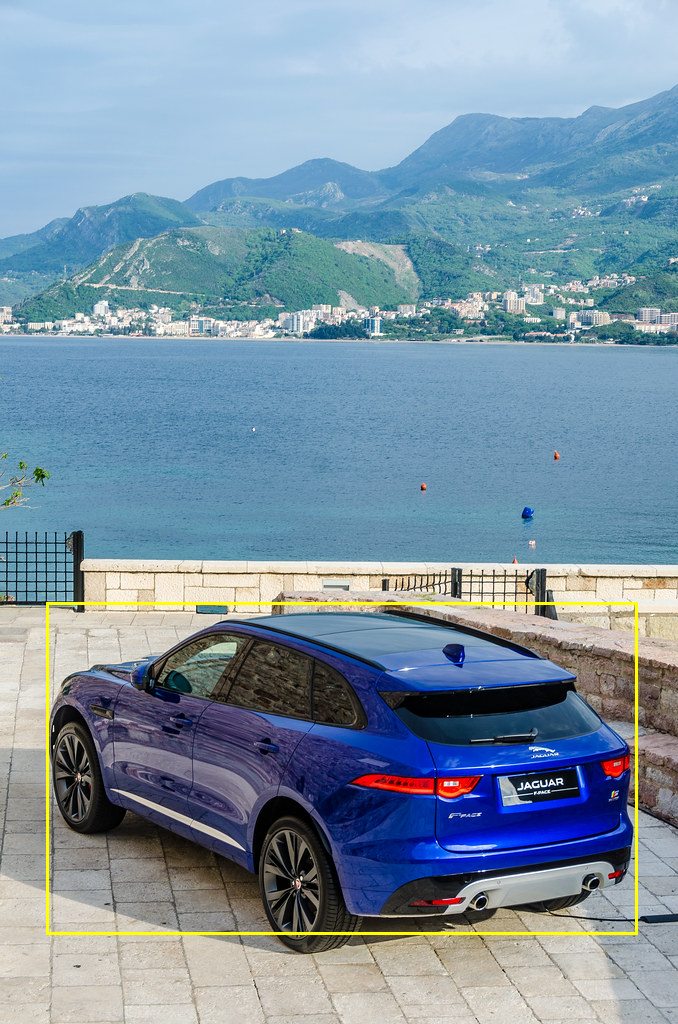

In [8]:
i=6
img = read_image(image_folder_path + data_bbox['img_path'][i])
bbox = [data_bbox['bbox_x1'][i],data_bbox['bbox_y1'][i],data_bbox['bbox_x2'][i],data_bbox['bbox_y2'][i]]
bbox = torch.tensor(bbox, dtype=torch.int)
bbox = bbox.unsqueeze(0)
print(bbox)
img=torchvision.utils.draw_bounding_boxes(img, bbox, width=3, colors=(255,255,0))
img = torchvision.transforms.ToPILImage()(img)
display(img)

In [9]:
df = data_bbox.copy()

In [10]:
df

,img_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,bd3138e00c925841a3934f3075f9c734.jpg,412,28,745,185
1,7b9bf41480eafc0c11d2e56502a93b45.jpg,250,229,860,634
2,ca56229ef626d9e0e24a496c5e490018.jpg,361,231,966,628
3,308f316edd39e74f7636fc8a40eeb712.jpg,151,230,925,655
4,bc7b5c4b60a7bcd4e477755b64c69b34.jpg,35,219,939,657
...,...,...,...,...,...
6453,910b7b2b480f9df5751ef22206e79532.jpg,162,127,830,563
6454,6ebab0ac8470e8614d9fa41ac6ff4121.jpg,152,614,806,900
6455,6d7bb960d07b7eecb3e875dca4c30605.jpg,3,294,675,908
6456,829d197c86a0363f9e31573f0312ff8b.jpg,70,132,902,512


In [11]:
len(df['img_path'].unique().tolist())

6458

# Create data class:

In [12]:
class CarDataset(object):
    def __init__(self, df, IMG_DIR, transforms=None):
        self.a = 0
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['img_path'].unique().tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_ids)
        
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df['img_path'] == image_id]
        image = cv2.imread(self.img_dir+image_id,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros((records.shape[0],), dtype=torch.int64)
    
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        return image.clone().detach(), target, image_id

In [13]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2()
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2()
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

Let`s show how work our class dataset

In [14]:
CD = CarDataset(df, image_folder_path, get_train_transform())

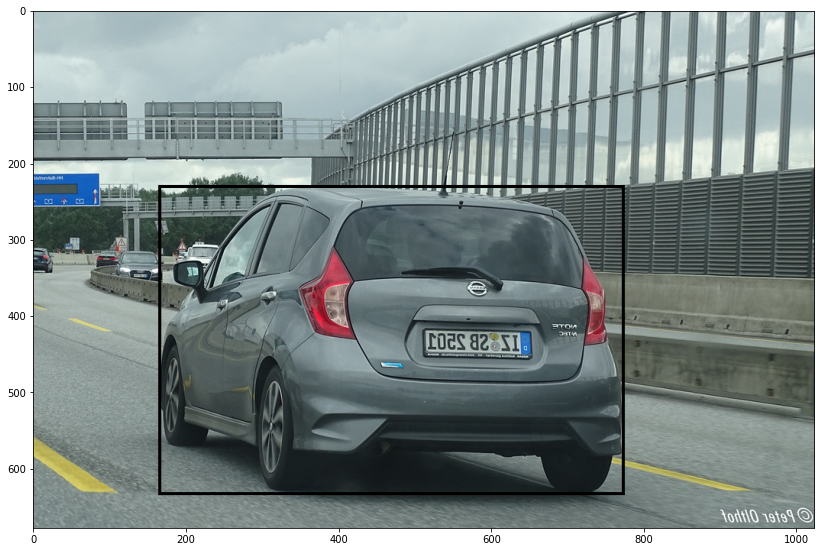

In [15]:
fig = plt.figure(figsize=(14, 10))
sample = CD[1]
# print(sample[1])
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], width=4
).permute(1, 2, 0))

# Split data and create dataloaders:

In [16]:
image_ids = df['img_path'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]
valid_df = df[df['img_path'].isin(valid_ids)]
train_df = df[df['img_path'].isin(train_ids)]
train_df.shape,valid_df.shape

((5793, 5), (665, 5))

In [17]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = CarDataset(train_df, image_folder_path, get_train_transform())
valid_dataset = CarDataset(valid_df, image_folder_path, get_valid_transform())

indices = torch.randperm(len(train_dataset)).tolist()
train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)


valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

# Model:
I use fasterrcnn_resnet50_fpn pre-trained on COCO dataset

In [52]:
num_classes = 2  # 1 class (car) + background

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [53]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train our model:

In [54]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets,_ in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) 
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") 
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        
    all_losses_dict = pd.DataFrame(all_losses_dict)
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [55]:
num_epochs=3

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_data_loader, device, epoch)

  0%|          | 0/2897 [00:00<?, ?it/s]

Epoch 0, lr: 0.005000, loss: 0.045891, loss_classifier: 0.015376, loss_box: 0.023071, loss_rpn_box: 0.006082, loss_object: 0.001362


  0%|          | 0/2897 [00:00<?, ?it/s]

Epoch 1, lr: 0.005000, loss: 0.030580, loss_classifier: 0.009947, loss_box: 0.014850, loss_rpn_box: 0.004896, loss_object: 0.000886


  0%|          | 0/2897 [00:00<?, ?it/s]

Epoch 2, lr: 0.005000, loss: 0.028681, loss_classifier: 0.009258, loss_box: 0.013948, loss_rpn_box: 0.004624, loss_object: 0.000851


# Show resault:

In [69]:
def apply_nms(orig_prediction, iou_thresh=0.2):
    

    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

In [70]:
img,target,_ = valid_dataset[43]
model.eval()
with torch.no_grad():
    prediction = model([img.to('cuda')])[0]
    
nms_prediction = apply_nms(prediction, iou_thresh=0.7)

REAL BOXES


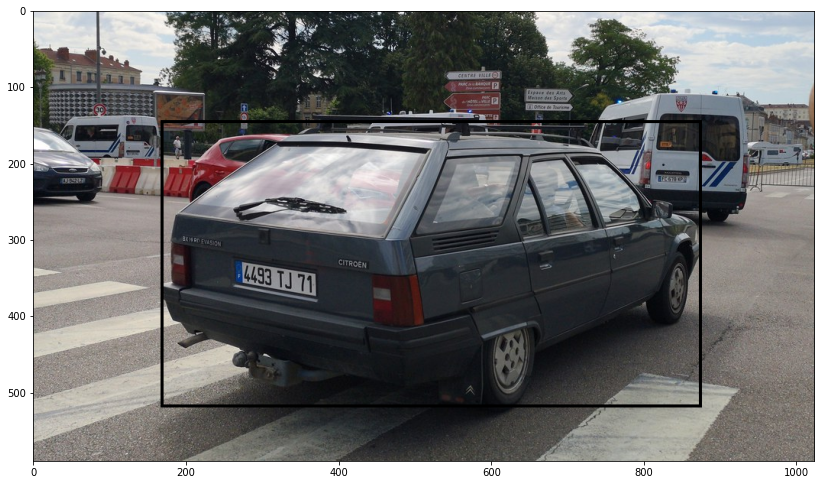

In [71]:
print("REAL BOXES")
fig = plt.figure(figsize=(14, 10))
sample = valid_dataset[43]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], width=4
).permute(1, 2, 0))

PREDICTED BOXES


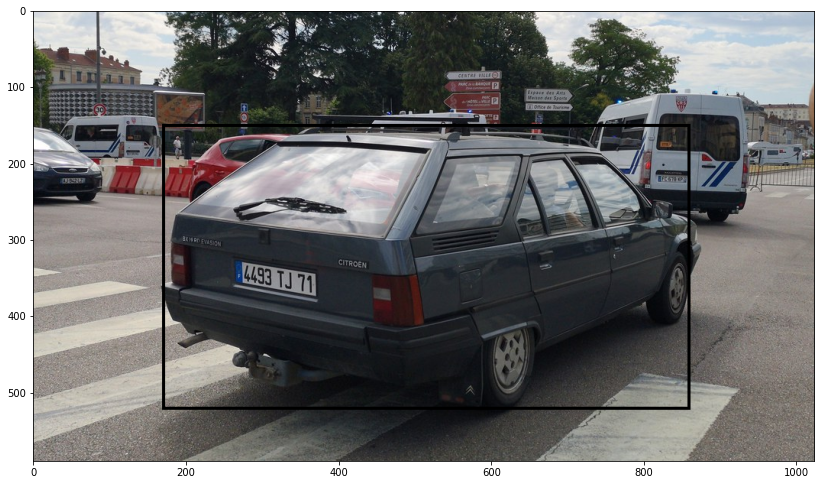

In [72]:
print("PREDICTED BOXES")
fig = plt.figure(figsize=(14, 10))
sample = valid_dataset[43]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(img_int,
    nms_prediction['boxes'][nms_prediction['scores'] > 0.8], width=4
).permute(1, 2, 0))